In [1]:
# First part


#Importing the data 
#Adapted from https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies
%matplotlib inline


import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt

# Glob the training data and load a single image path
training_paths = pathlib.Path('/modules/cs342/Assignment2/FullTraining').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])

masks_paths = pathlib.Path('/modules/cs342/Assignment2/FullTraining').glob('*/masks/*.png')
masks_sorted = sorted([x for x in masks_paths])

testing_paths = pathlib.Path('/modules/cs342/Assignment2/FullTesting').glob('*/images/*.png')
testing_sorted = sorted([x for x in testing_paths])




# Preprocessing and Feature Engineering

In [2]:
#gray version
from skimage.color import rgb2gray
def gray_scale(im):
    im_gray = rgb2gray(im)
    return im_gray

In [10]:
#Here we try to apply HoG tecnique:
from skimage.feature import hog
from skimage import data, exposure

#should apply this to gray scale image

def hog(im):
    fd,hog_image = hog(im, orientations=16, pixels_per_cell=(2, 2),cells_per_block=(3, 3),visualise=True)
    return fd,hog_image

In [11]:
# Second way of doing HoG using cv2
# gives better results so to be preferred
# Inspired from:https://www.learnopencv.com/histogram-of-oriented-gradients/
import cv2
 
def hog2(img):
    
    img = rgb2gray(img)
    img = np.float32(img) / 255.0
 
    # Calculate gradient
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
 
    # Python Calculate gradient magnitude and direction ( in degrees )
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
   
    return mag

In [12]:
#Here we try to use thresholding to separate nuclei from background
#taken from https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies
from skimage.filters import threshold_otsu


def otsu(im):
    thresh_val = threshold_otsu(im)
    mask = np.where(im > thresh_val, 1, 0)

    # Make sure the larger portion of the mask is considered background
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)
    return mask

In [13]:

# Data augmentation
# code taken from https://www.kaggle.com/shenmbsw/data-augmentation-and-tensorflow-u-net

import skimage.io
import random
from skimage import transform
def read_image_labels(image_id):
    # most of the content in this function is taken from 'Example Metric Implementation' kernel 
    # by 'William Cukierski'
    image_file = "/modules/cs342/Assignment2/FullTraining/{}/images/{}.png".format(image_id,image_id)
    mask_file = "/modules/cs342/Assignment2/FullTraining/{}/masks/*.png".format(image_id)
    image = skimage.io.imread(image_file)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = index + 1
    return image, labels

def data_aug(image,label,angel=30,resize_rate=0.9):
    flip = random.randint(0, 1)
    size = image.shape[0]
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    # Create Afine transform
    afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
    # Apply transform to image data
    image = transform.warp(image, inverse_map=afine_tf,mode='edge')
    label = transform.warp(label, inverse_map=afine_tf,mode='edge')
    # Randomly corpping image frame
    image = image[w_s:w_s+size,h_s:h_s+size,:]
    label = label[w_s:w_s+size,h_s:h_s+size]
    # Ramdomly flip frame
    if flip:
        image = image[:,::-1,:]
        label = label[:,::-1]
    return image, label


In [59]:
# Idea: maybe image erosion will detach ovderlapping masks
# also tries opening: erosion>dilation
from skimage.morphology import binary_erosion
from skimage.morphology import erosion
from skimage.morphology import opening

def erode(mask):
    er = binary_erosion(mask, selem=None, out=None)
    return er

def op_morph(mask):
    op = opening(mask)
    return op

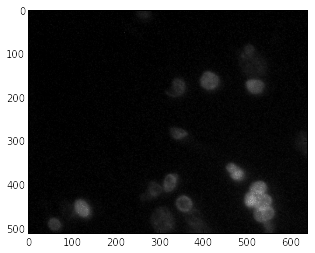

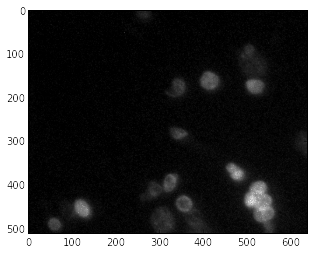

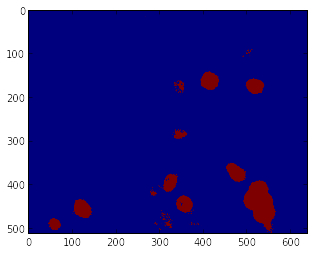

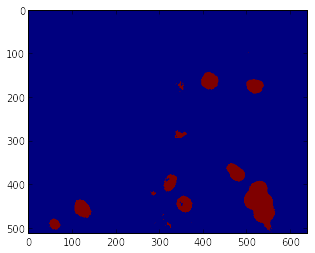

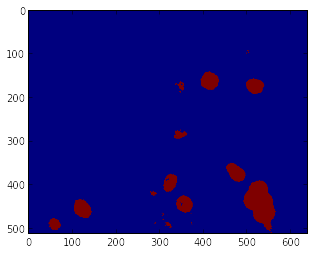

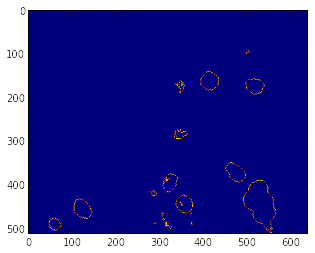

In [68]:
%matplotlib inline

im = imageio.imread(str(testing_sorted[40]))
plt.imshow(im)
plt.show()

im_gray = gray_scale(im)
plt.imshow(im_gray,cmap='gray')
plt.show()

mask = otsu(im_gray)
plt.imshow(mask)
plt.show()

er= erode(mask)
plt.imshow(er)
plt.show()

op= opening(mask)
plt.imshow(op)
plt.show()

hog = hog2(op)
plt.imshow(hog)
plt.show()



In [72]:
# Deriving individual mask for each object

def find_labels(mask):    
    labels, numlabels = ndimage.label(mask)    
    label_arrays = []
    im_df = pd.DataFrame(columns=["ImageID","EncodedPixels"])
    for n in range(1, numlabels+1, 1):
        label_mask = np.where(labels == n, 1, 0)
        #only takes masks abovea certan threshold
        if sum(sum(label_mask))>=13:        
            label_arrays.append(label_mask)
        else:
            mask = np.where(labels == n, 0, mask)
            numlabels += -1
    labels, nlabels = ndimage.label(mask)
    return (labels,numlabels)

In [73]:
#rle encoding
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] 
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [75]:
def create_row(labels, numlabels, image_id):
    row = pd.DataFrame(columns=["ImageID","EncodedPixels"])
    for n in range(1, numlabels+1, 1):
            label_mask = np.where(labels == n, 1, 0)
            rle_string = rle_encoding(label_mask)
            series = pd.Series({'ImageID': image_id, 'EncodedPixels': rle_string})
            row = row.append(series, ignore_index=True)

    return row

In [57]:
# Prediction without Neural Network

In [66]:
import pandas as pd
import skimage
from scipy import ndimage 
from skimage.morphology import watershed
from skimage.feature import peak_local_max
# prediction using no NN
def predict_no_NN():
    
    #df to output
    df = pd.DataFrame(columns=["ImageID","EncodedPixels"])
    for image_path in testing_sorted:
        im_id = image_path.parts[-3]
        im = imageio.imread(str(image_path))
        im_gray = gray_scale(im)
        mask = otsu(im_gray)
        #this is an additional step,in case remove
        op = op_morph(mask)
        labels,numlabels = find_labels(op)
        row = create_row(labels,numlabels,im_id)
        df = df.append(row, ignore_index=True)
        
        print('New image added')    
    return df


In [67]:
df = predict_no_NN()
df.to_csv(path_or_buf='../submission_no_NN_er.csv', index=None)

New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New image added
New imag

# Neural Networks : MLP and Deep Learning

In [76]:
# Before we can feed data to the MLP we need to rescale all the pics
# and then flatten the pictures into 1d vectors
# Code taken from: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
import os
import sys
import random
import warnings

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '/modules/cs342/Assignment2/FullTraining/'
TEST_PATH = '/modules/cs342/Assignment2/FullTesting/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img


Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:53<00:00,  5.92it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 88.87it/s]


In [77]:
# Here I flatten all the various different pictures
X_train_pixels= []
for picture in X_train:
    X_train_pixels.append(picture.flatten())
X_train_pixels= np.asarray(X_train_pixels)    
    
Y_train_pixels= []
for picture in Y_train:
    Y_train_pixels.append(picture.flatten())
Y_train_pixels= np.asarray(Y_train_pixels)  
    
X_test_pixels= []
for picture in X_test:
    X_test_pixels.append(picture.flatten()) 
X_test_pixels= np.asarray(X_test_pixels) 

In [114]:
# Train the MLPClassifier from sklearn
# Some of the parameters were done via gridsearch
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(20,10,10,20))
mlp.fit(X_train_pixels[:150],Y_train_pixels[:150])


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 10, 10, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

/local/java/python-pip-packages/lib64/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


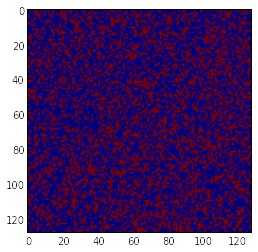

In [115]:
plt.imshow(mlp.predict(X_test_pixels[64]).reshape((128,128))) 

In [116]:
predictions = [mlp.predict(x).reshape((128,128)) for x in X_test_pixels ]

/local/java/python-pip-packages/lib64/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/local/java/python-pip-packages/lib64/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/local/java/python-pip-packages/lib64/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape

In [117]:
# Resize our predicted test values to their original image sizes
preds_test_resized = []
for i in range(len(predictions)):
    preds_test_resized.append(resize(np.squeeze(predictions[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

In [119]:
predictions = [rle_encoding(x) for x in preds_test_resized]

In [120]:
# This will be our final dataframe

#import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt
import skimage
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

df = pd.DataFrame(columns=["ImageID","EncodedPixels"])

# Glob the training data and load a single image path
testing_paths = pathlib.Path('/modules/cs342/Assignment2/FullTesting/').glob('*/images/*.png')
testing = [x for x in testing_paths]
for i,image_path in enumerate(testing):
    image_id = image_path.parts[-3]
    image = imageio.imread(str(image_path))
    series = pd.Series({'ImageID': image_id, 'EncodedPixels': predictions[i]})

    df = df.append(series, ignore_index=True)

  
    
df.to_csv(path_or_buf='../submission_MLP.csv', index=None)

In [110]:
#Grid search to find best parameters
# DO NOT RUN, VERY SLOW!!
from sklearn.model_selection import GridSearchCV
parameters={
'hidden_layer_sizes':[(20,), (20,10),(20,20,20) ,(30,30,30)],
'activation':['logistic', 'tanh', 'relu'],
'solver':['lbfgs', 'sgd', 'adam'],
'alpha':[0.1,0.01,0.001,0.0001,0.00001],
'batch_size':[1,10,50,100,200,500],
'learning_rate':['constant', 'invscaling', 'adaptive'],
'learning_rate_init':[0.1,0.01,0.001,0.0001,0.00001],
'max_iter':[100,200,500,1000]
}
 
#Grid Search Cross Validation
model = GridSearchCV(estimator=mlp,param_grid=parameters,cv=10)
model.fit(X_train_pixels,Y_train_pixels)
 
#Displaying best parameters selected via grid search
print('Best parameter set:')
best_parameters = model.best_estimator_.get_params()
print(best_parameters)

KeyboardInterrupt: 

# MLP with Feature Engineering- HoG

In [89]:
def get_hog_pics():
    hog_train = []
    hog_test = []
    for im in X_train:
        hog = hog2(im)
        hog_train.append(hog)
    for im in X_test:
        hog = hog2(im)
        hog_test.append(hog)
    return hog_train,hog_test
hog_train,hog_test = get_hog_pics()    

In [95]:
# Here I flatten all the various different pictures
X_train_hog_pixels= []
for picture in hog_train:
    X_train_hog_pixels.append(picture.flatten())
X_train_hog_pixels= np.asarray(X_train_hog_pixels)    
    
Y_train_pixels= []
for picture in Y_train:
    Y_train_pixels.append(picture.flatten())
Y_train_pixels= np.asarray(Y_train_pixels)  
    
X_test_hog_pixels= []
for picture in hog_test:
    X_test_hog_pixels.append(picture.flatten()) 
X_test_hog_pixels= np.asarray(X_test_hog_pixels) 

In [105]:
# Train the MLPClassifier from sklearn
# this time we use the hog picture for training
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(20,40,40,20))
mlp.fit(X_train_hog_pixels[:15],Y_train_pixels[:15])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 40, 40, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

/local/java/python-pip-packages/lib64/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


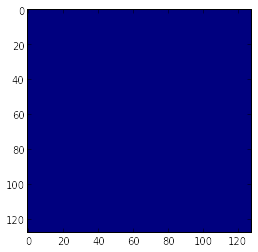

In [106]:
plt.imshow(mlp.predict(X_train_hog_pixels[10]).reshape((128,128))) 

In [108]:
predictions = [mlp.predict(x).reshape((128,128)) for x in X_test_hog_pixels ]

/local/java/python-pip-packages/lib64/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/local/java/python-pip-packages/lib64/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/local/java/python-pip-packages/lib64/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape

In [109]:
# Resize our predicted test values to their original image sizes
preds_test_resized = []
for i in range(len(predictions)):
    preds_test_resized.append(resize(np.squeeze(predictions[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

# MLP With Feature Engineering -Data Augmentation

In [ ]:
# MLP with Feature Engineering - Data Augmentation
# code inspired by https://www.kaggle.com/shenmbsw/data-augmentation-and-tensorflow-u-net

def get_aug_pics():
    aug_train = []
    aug_test = []
    for im in X_train:
        aug = data_aug(im)
        aug_train.append(aug)
    for im in X_test:
        aug = data_aug(im)
        aug_test.append(hog)
    return aug_train,aug_test
aug_train,aug_test = get_aug_pics()   


In [ ]:
# Here I flatten all the various different pictures
X_train_aug_pixels= []
for picture in aug_train:
    X_train_aug_pixels.append(picture.flatten())
X_train_aug_pixels= np.asarray(X_train_aug_pixels)    
    
Y_train_pixels= []
for picture in Y_train:
    Y_train_pixels.append(picture.flatten())
Y_train_pixels= np.asarray(Y_train_pixels)  
    
X_test_aug_pixels= []
for picture in aug_test:
    X_test_aug_pixels.append(picture.flatten()) 
X_test_aug_pixels= np.asarray(X_test_aug_pixels) 

In [ ]:
# Train the MLPClassifier from sklearn
# this time we use the data augmented pictures for training
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(20,40,40,20))
mlp.fit(X_train_aug_pixels[:15],Y_train_pixels[:15])

In [ ]:
plt.imshow(mlp.predict(X_train_aug_pixels[10]).reshape((128,128))) 

# Convolutional Neural Network


In [110]:
# Uses a modified version of a UNET
# Code inspired by https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
import os
import sys
import random
import warnings
 
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
 
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
 
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
 
import tensorflow as tf
from keras.layers import merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import BatchNormalization, Deconvolution2D, Conv1D, Conv2D, Conv2DTranspose, UpSampling2D, Lambda, Dense, Activation, Input, Dropout, MaxPooling2D, concatenate

from subprocess import check_output
print(check_output(["ls", "../input/"]).decode("utf8"))


#Funcs
# Define IoU metric, taken from
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
 
#DICE FUNCTION
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
 
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
AUG_PATH ='../input/stage1_train/augs'
TEST_PATH = '../input/stage1_test/'
 
    
# #data augmentation
# def data_aug(image,label,angel=30,resize_rate=0.9):
#     flip = random.randint(0, 1)
#     size = image.shape[0]
#     rsize = random.randint(np.floor(resize_rate*size),size)
#     w_s = random.randint(0,size - rsize)
#     h_s = random.randint(0,size - rsize)
#     sh = random.random()/2-0.25
#     rotate_angel = random.random()/180*np.pi*angel
#     # Create Afine transform
#     afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
#     # Apply transform to image data
#     image = transform.warp(image, inverse_map=afine_tf,mode='edge')
#     label = transform.warp(label, inverse_map=afine_tf,mode='edge')
#     # Randomly corpping image frame
#     image = image[w_s:w_s+size,h_s:h_s+size,:]
#     label = label[w_s:w_s+size,h_s:h_s+size]
#     # Ramdomly flip frame
#     if flip:
#         image = image[:,::-1,:]
#         label = label[:,::-1]
#     return image, label


# def make_data_augmentation(image_ids,split_num):
#     for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
#         image,labels = read_image_labels(image_id)
#         if not os.path.exists("../input/stage1_train/{}/augs/".format(image_id)):
#             os.makedirs("../input/stage1_train/{}/augs/".format(image_id))
#         if not os.path.exists("../input/stage1_train/{}/augs_masks/".format(image_id)):
#             os.makedirs("../input/stage1_train/{}/augs_masks/".format(image_id))
            
#         # also save the original image in augmented file 
#         plt.imsave(fname="../input/stage1_train/{}/augs/{}.png".format(image_id,image_id), arr = image)
#         plt.imsave(fname="../input/stage1_train/{}/augs_masks/{}.png".format(image_id,image_id),arr = labels)

#         for i in range(split_num):
#             new_image, new_labels = data_aug(image,labels,angel=5,resize_rate=0.9)
#             aug_img_dir = "../input/stage1_train/{}/augs/{}_{}.png".format(image_id,image_id,i)
#             aug_mask_dir = "../input/stage1_train/{}/augs_masks/{}_{}.png".format(image_id,image_id,i)
#             plt.imsave(fname=aug_img_dir, arr = new_image)
#            plt.imsave(fname=aug_mask_dir,arr = new_labels)

# def clean_data_augmentation(image_ids):
#     for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
#         if os.path.exists("../input/stage1_train/{}/augs/".format(image_id)):
#             shutil.rmtree("../input/stage1_train/{}/augs/".format(image_id))
#         if os.path.exists("../input/stage1_train/{}/augs_masks/".format(image_id)):
#             shutil.rmtree("../input/stage1_train/{}/augs_masks/".format(image_id))


# image_ids = check_output(["ls", "../input/stage1_train/"]).decode("utf8").split()
# split_num = 10
# make_data_augmentation(image_ids,split_num)
# clean_data_augmentation(image_ids)

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
 
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
 
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)
 
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)
 
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
 
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
 
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[mean_iou])
model.summary()
 
 
 
 

 
 
# Fit model
#earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=10, epochs=10,
                    callbacks=[ checkpointer])
 
 
 
 
 
 
import pandas as pd
from skimage.filters import threshold_otsu
from scipy import ndimage
import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from scipy import ndimage
 
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou, 'dice_coef_loss': dice_coef_loss})
 
def rle_encoding(x):
    '''
   x: numpy array of shape (height, width), 1 - mask, 0 - background
   Returns run length as list
   '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])
 
def RLE_mask(mask,image_id,df):
    '''
   Returns pandas dataframe of each RLE string for each (predicted) nuclei of an image
   '''
    # Deriving individual mask for each object
    labels, numlabels = ndimage.label(mask)     #labels each component with different number
    label_arrays = []
    im_df = pd.DataFrame(columns=["ImageID","EncodedPixels"])
    for n in range(1, numlabels+1, 1):
        label_mask = np.where(labels == n, 1, 0)
        if sum(sum(label_mask))>=10:        # checks if the nuclei is big enough to be considered
            label_arrays.append(label_mask)
        else:
            mask = np.where(labels == n, 0, mask)
            numlabels += -1
    labels, emptyarg = ndimage.label(mask)
   
    # Watershed by distance to edge
    #distance = ndi.distance_transform_edt(label)
    #local_maxi = peak_local_max(distance, indices=False, labels=label)
    #markers = ndi.label(local_maxi)[0]
    #label = watershed(-distance, markers, mask=label)
 
    #Adding to df
    im_df = pd.DataFrame(columns=["ImageID","EncodedPixels"])
    for n in range(1, numlabels+1, 1):
            label_mask = np.where(labels == n, 1, 0)
            rle_string = rle_encoding(label_mask)
            series = pd.Series({'ImageID': image_id, 'EncodedPixels': rle_string})
            im_df = im_df.append(series, ignore_index=True)
    return im_df
 
 
# MAIN
 
import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt
import skimage
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
 
#predicted test values
preds_test = model.predict(X_test, verbose=1)
 
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))
 
# This will be our final dataframe
df = pd.DataFrame(columns=["ImageID","EncodedPixels"])
 
j=0
# RLE encode the test data
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
   
    image_id = id_
    image_label = preds_test_upsampled[j]
   
    #CONVERT PROBABILISTIC PREDICTION TO BINARY
    from skimage.filters import threshold_otsu
    thresh_val = threshold_otsu(image_label)
    newmask = np.where(image_label > thresh_val, 1, 0)
   
    add_to_df = RLE_mask(newmask,image_id,df)
    df = df.append(add_to_df, ignore_index=True)
    j+=1
 
print(df)
df.to_csv('CNNsubmission.csv', index=False)
 
 
 
#See stuff
image_label = preds_test_upsampled[0]
   
#CONVERT PROBABILISTIC PREDICTION TO BINARY
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(image_label)
print(thresh_val)
mask = np.where(image_label > thresh_val, 1, 0)
mask = image_label
flat = mask.flatten()
newmask=flat.reshape((mask.shape[0],mask.shape[1]))
plt.imshow(newmask)

Using Theano backend.


ImportError: cannot import name Conv2DTranspose